In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
import copy
import random
import importlib
import algos as al
import imageio

In [2]:
def generate_random_graph(node_count, connectivity):
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(range(1, node_count + 1))

    # Ensure at least min_edges are added for connectivity

    # Add edges to achieve the desired connectivity
    while len(list(nx.isolates(G))) >0:
        node1 = random.randint(1, node_count)
        node2 = random.randint(1, node_count)
        if node1 != node2 and not G.has_edge(node1, node2):
            G.add_edge(node1, node2)

    # Add remaining edges randomly
    remaining_edges = int(node_count * (node_count - 1) * connectivity / 2)
    for _ in range(remaining_edges):
        node1 = random.randint(1, node_count)
        node2 = random.randint(1, node_count)
        if node1 != node2 and not G.has_edge(node1, node2):
            G.add_edge(node1, node2)

    return G

In [3]:
def generate_sf_graph(n):
    G = nx.scale_free_graph(n=n,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    G = nx.Graph(G)
    G = nx.convert_node_labels_to_integers(G)
    components = list(nx.connected_components(G))
    while len(components) > 1:
        G.add_edge(components[0].pop(), components[1].pop())
        components = list(nx.connected_components(G))
    return G

In [4]:
def KMJ(v, f, i, min_edges, max_iter=1500):
    """
    Generates a planar scale-free graph using the KMJ method.
    
    v: Number of vertices
    f: Distribution function (callable)
    i: Number of iterations
    min_edges: Minimum number of edges before stopping
    """
    # Step 1: Create vertices
    G = nx.Graph()
    G.add_nodes_from(range(v))
    
    # Assign probabilities based on distribution function
    probabilities = f(v)
    probabilities /= probabilities.sum()  # Normalize to make it a probability distribution
    
    # Step 2: Add edges iteratively
    edge_count = 0
    iter = 0
    while ((iter <i or edge_count<min_edges or len(list(nx.connected_components(G)))>1)and iter<max_iter) :
        
        # Select first vertex based on probability distribution
        vertex1 = np.random.choice(range(v), p=probabilities)
        
        # Select second vertex purely randomly
        vertex2 = random.randint(0, v - 1)
        
        
        # Avoid self-loops
        if vertex1 == vertex2:
            continue
        
        # Add edge if planarity is preserved
        if (not G.has_edge(vertex1,vertex2)):            
            G.add_edge(vertex1, vertex2)
            
            if nx.check_planarity(G)[0]:  # Check if still planar
                edge_count += 1
            else:
                G.remove_edge(vertex1, vertex2)  # Revert if not planar
                
        iter+=1
    return G

In [6]:
import scipy.stats as stats
v = 50  # Number of vertices
i = 1500  # Max iterations
min_edges = 150  # Minimum edges before stopping

def normal_distribution(v, mu=None, sigma=None):
    """
    Creates a normal distribution centered around mu with standard deviation sigma.
    """
    if mu is None:
        mu = v / 2  # Center around the middle vertex
    if sigma is None:
        sigma = v / 4  # Control spread

    x = np.arange(v)
    probabilities = stats.norm.pdf(x, loc=mu, scale=sigma)  # Normal PDF values
    return probabilities

In [51]:
sf_arr = np.array([])
r_arr = np.array([])
kmj_arr = np.array([])

for i in range (100):
    G = nx.scale_free_graph(n=50,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    pager = nx.pagerank(G,max_iter=1000)
    sf_arr = np.append(sf_arr,np.array(list(pager.values())))
    
    gr = generate_random_graph(50, 1)
    pager = nx.pagerank(gr,max_iter=1000)
    r_arr = np.append(r_arr,np.array(list(pager.values())))
    
    k = KMJ(50,normal_distribution,500,150,1000)
    pager = nx.pagerank(k,max_iter=1000)
    kmj_arr = np.append(kmj_arr,np.array(list(pager.values())))
    
    
    

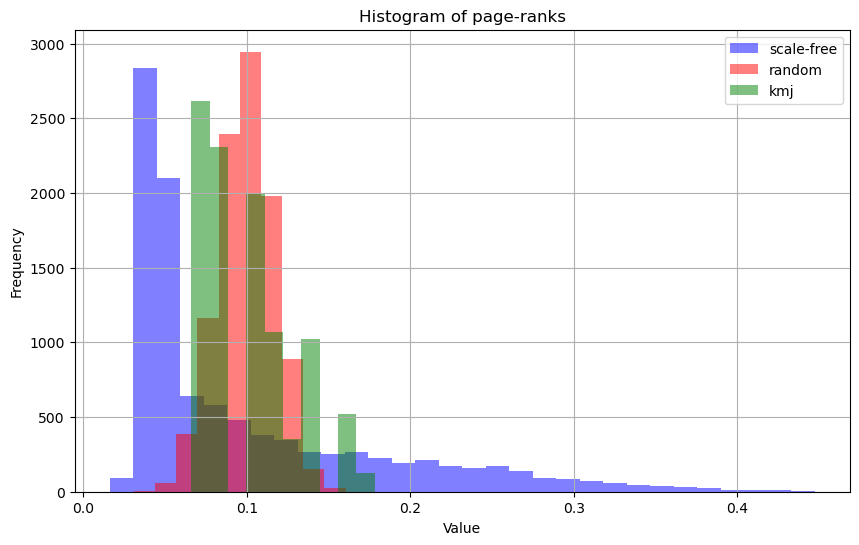

In [36]:
# Plotting histogram
plt.figure(figsize=(10, 6))

# Histogram for UN_walks
plt.hist(sf_arr, bins=30, alpha=0.5, color='blue', label='scale-free')

# Histogram for PR_walks
plt.hist(r_arr, bins=10, alpha=0.5, color='red', label='random')

plt.hist(kmj_arr, bins=10, alpha=0.5, color='green', label='kmj')

plt.title('Histogram of page-ranks')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()

In [52]:
sf_arr = np.array([])
r_arr = np.array([])
kmj_arr = np.array([])

for i in range (100):
    G = nx.scale_free_graph(n=50,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    pager = nx.betweenness_centrality(G)
    sf_arr = np.append(sf_arr,np.array(list(pager.values())))
    
    gr = generate_random_graph(50, 1)
    pager = nx.betweenness_centrality(gr)
    r_arr = np.append(r_arr,np.array(list(pager.values())))
    
    k = KMJ(50,normal_distribution,500,150,1000)
    pager = nx.betweenness_centrality(k)
    kmj_arr = np.append(kmj_arr,np.array(list(pager.values())))

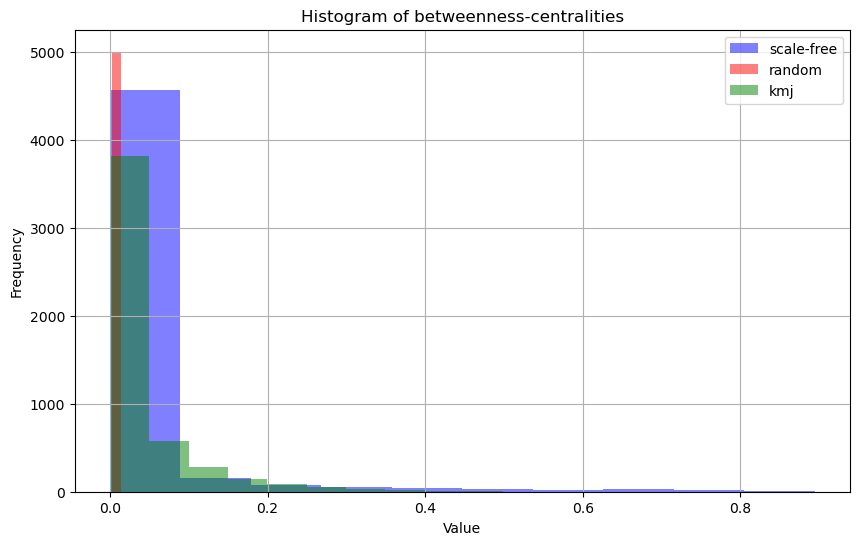

In [57]:
# Plotting histogram
plt.figure(figsize=(10, 6))

# Histogram for UN_walks
plt.hist(sf_arr, bins=10, alpha=0.5, color='blue', label='scale-free')

# Histogram for PR_walks
plt.hist(r_arr, bins=1, alpha=0.5, color='red', label='random')

plt.hist(kmj_arr, bins=10, alpha=0.5, color='green', label='kmj')

plt.title('Histogram of betweenness-centralities')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()

In [31]:
sf_arr = np.array([])
r_arr = np.array([])
kmj_arr = np.array([])

for i in range (500):
    G = nx.scale_free_graph(n=50,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    pager = nx.degree_centrality(G)
    sf_arr = np.append(sf_arr,np.array(list(pager.values())))
    
    gr = generate_random_graph(50, 1)
    pager = nx.degree_centrality(gr)
    r_arr = np.append(r_arr,np.array(list(pager.values())))
    
    k = KMJ(50,normal_distribution,500,150,1000)
    pager = nx.degree_centrality(k)
    kmj_arr = np.append(kmj_arr,np.array(list(pager.values())))

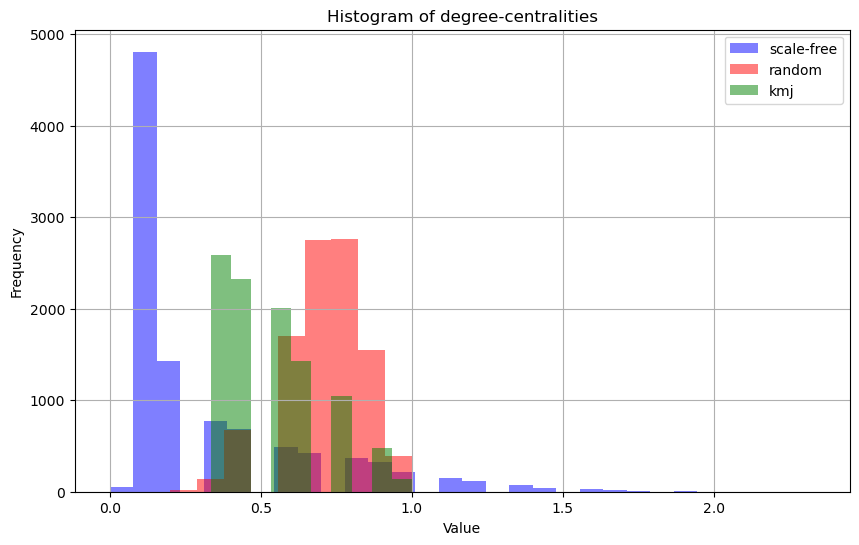

In [ ]:
# Plotting histogram
plt.figure(figsize=(10, 6))

# Histogram for UN_walks
plt.hist(sf_arr, bins=30, alpha=0.5, color='blue', label='scale-free')

# Histogram for PR_walks
plt.hist(r_arr, bins=10, alpha=0.5, color='red', label='random')

plt.hist(kmj_arr, bins=10, alpha=0.5, color='green', label='kmj')

plt.title('Histogram of degree-centralities')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()

In [47]:
sf_arr = np.array([])
r_arr = np.array([])
kmj_arr = np.array([])

for i in range (500):
    G = nx.scale_free_graph(n=50,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    pager = nx.pagerank(nx.line_graph(G),max_iter=1000)
    sf_arr = np.append(sf_arr,np.array(list(pager.values())))
    
    gr = generate_random_graph(50, 1)
    pager = nx.pagerank(nx.line_graph(gr),max_iter=1000)
    r_arr = np.append(r_arr,np.array(list(pager.values())))
    
    k = KMJ(50,normal_distribution,500,150,1000)
    pager = nx.pagerank(nx.line_graph(k),max_iter=1000)
    kmj_arr = np.append(kmj_arr,np.array(list(pager.values())))
    
    
    

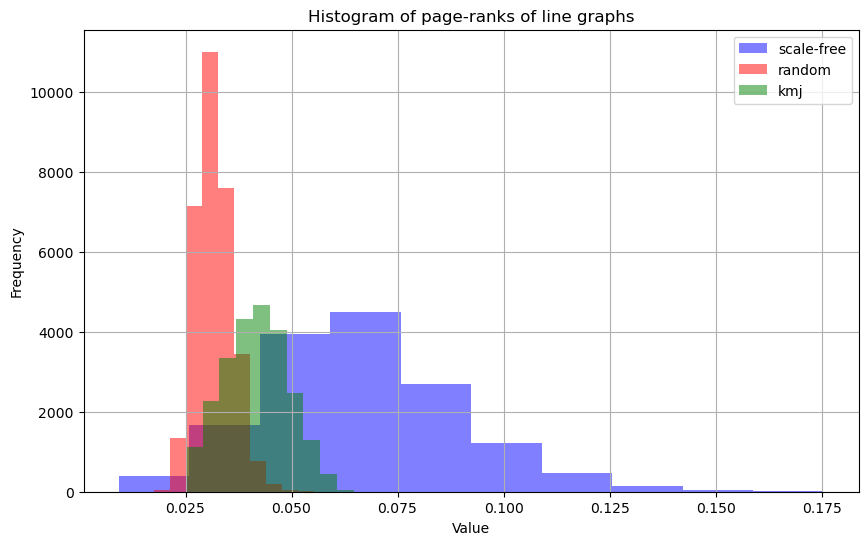

In [ ]:
# Plotting histogram
plt.figure(figsize=(10, 6))

# Histogram for UN_walks
plt.hist(sf_arr, bins=10, alpha=0.5, color='blue', label='scale-free')

# Histogram for PR_walks
plt.hist(r_arr, bins=10, alpha=0.5, color='red', label='random')

plt.hist(kmj_arr, bins=10, alpha=0.5, color='green', label='kmj')

plt.title('Histogram of page-ranks of line graphs')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
sf_arr = np.array([])
r_arr = np.array([])
kmj_arr = np.array([])

for i in range (500):
    G = nx.scale_free_graph(n=50,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    pager = nx.betweenness_centrality(nx.line_graph(G))
    sf_arr = np.append(sf_arr,np.array(list(pager.values())))
    
    gr = generate_random_graph(50, 1)
    pager = nx.betweenness_centrality(nx.line_graph(gr))
    r_arr = np.append(r_arr,np.array(list(pager.values())))
    
    k = KMJ(50,normal_distribution,500,150,1000)
    pager = nx.betweenness_centrality(nx.line_graph(k))
    kmj_arr = np.append(kmj_arr,np.array(list(pager.values())))
    
    
    

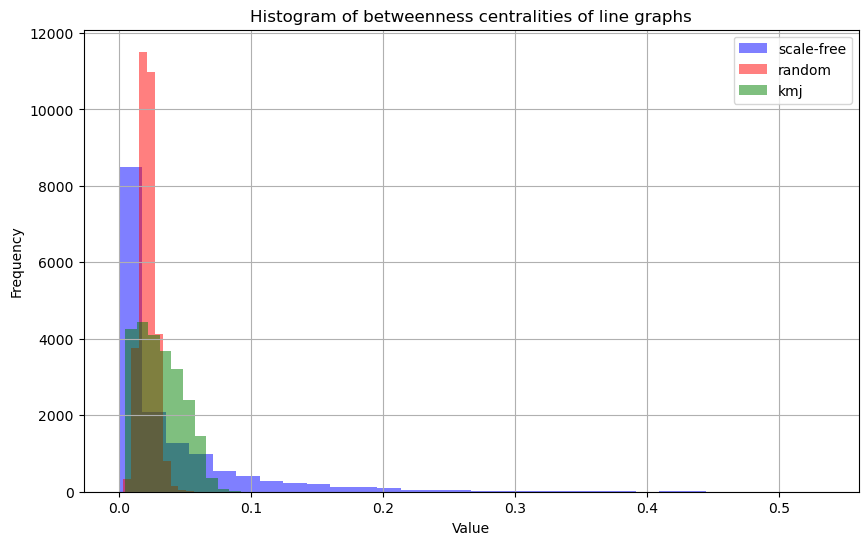

In [41]:
# Plotting histogram
plt.figure(figsize=(10, 6))

# Histogram for UN_walks
plt.hist(sf_arr, bins=30, alpha=0.5, color='blue', label='scale-free')

# Histogram for PR_walks
plt.hist(r_arr, bins=10, alpha=0.5, color='red', label='random')

plt.hist(kmj_arr, bins=10, alpha=0.5, color='green', label='kmj')

plt.title('Histogram of betweenness centralities of line graphs')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()

In [45]:
sf_arr = np.array([])
r_arr = np.array([])
kmj_arr = np.array([])

for i in range (500):
    G = nx.scale_free_graph(n=50,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    pager = nx.degree_centrality(nx.line_graph(G))
    sf_arr = np.append(sf_arr,np.array(list(pager.values())))
    
    gr = generate_random_graph(50, 1)
    pager = nx.degree_centrality(nx.line_graph(gr))
    r_arr = np.append(r_arr,np.array(list(pager.values())))
    
    k = KMJ(50,normal_distribution,500,150,1000)
    pager = nx.degree_centrality(nx.line_graph(k))
    kmj_arr = np.append(kmj_arr,np.array(list(pager.values())))
    
    

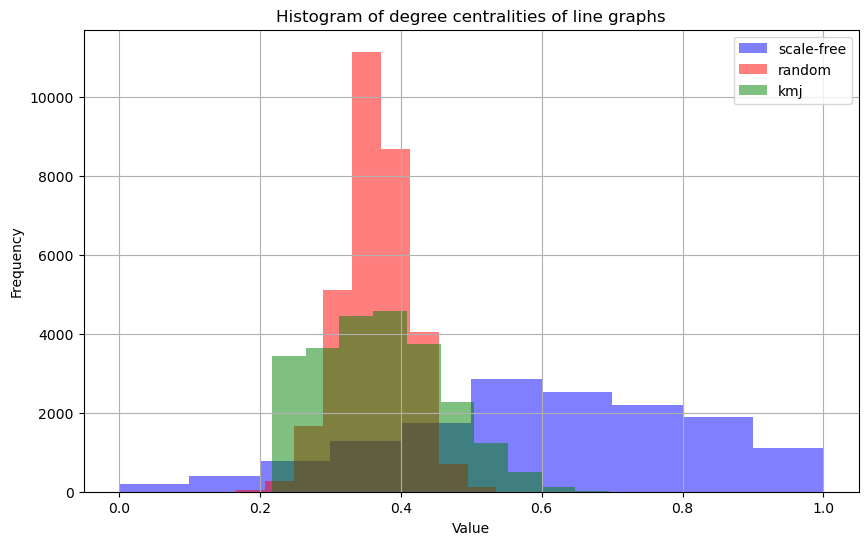

In [46]:
# Plotting histogram
plt.figure(figsize=(10, 6))

# Histogram for UN_walks
plt.hist(sf_arr, bins=10, alpha=0.5, color='blue', label='scale-free')

# Histogram for PR_walks
plt.hist(r_arr, bins=10, alpha=0.5, color='red', label='random')

plt.hist(kmj_arr, bins=10, alpha=0.5, color='green', label='kmj')

plt.title('Histogram of degree centralities of line graphs')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()